In [1]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms
import torchvision.datasets as datasets



print('done')

done


In [2]:
# mnist data reader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x108921710>,
 <torch.utils.data.dataloader.DataLoader at 0x108921908>)

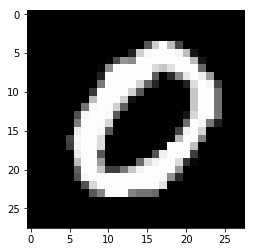

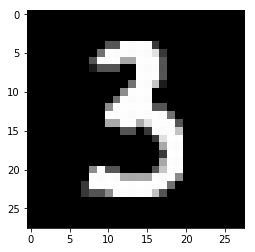

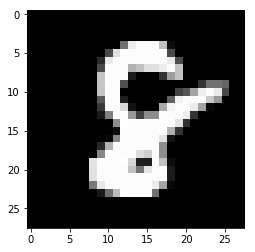

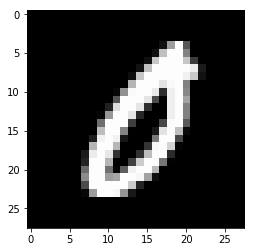

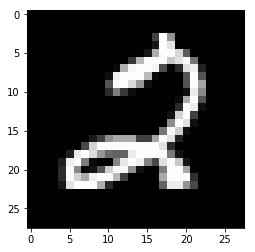

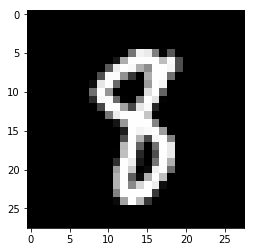

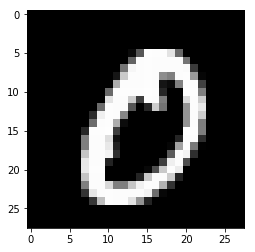

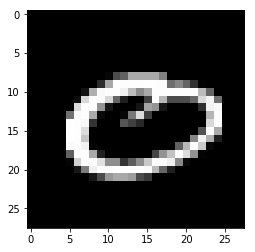

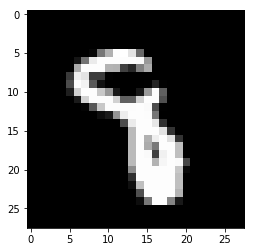

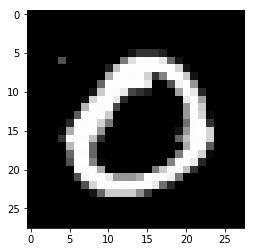

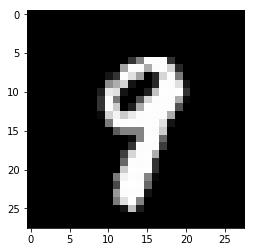

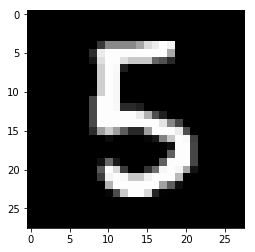

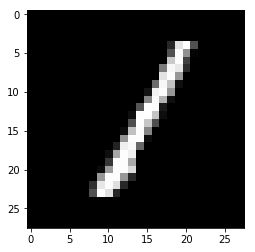

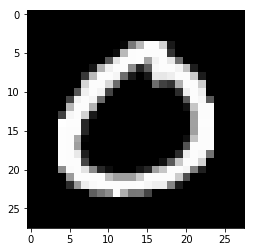

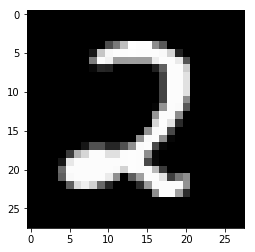

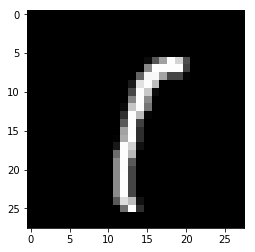

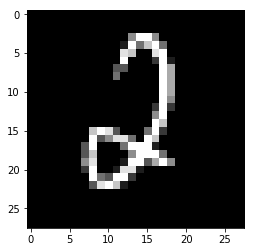

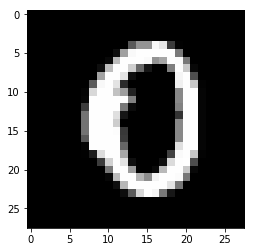

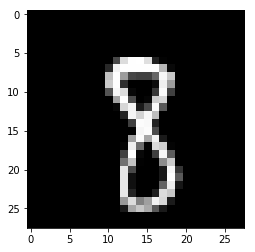

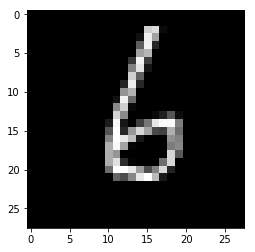

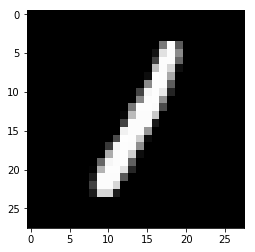

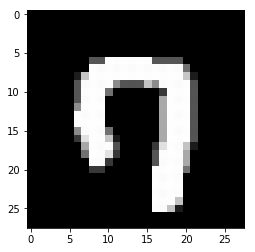

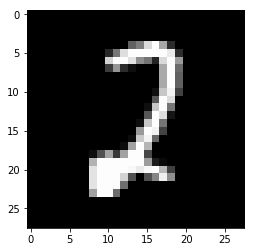

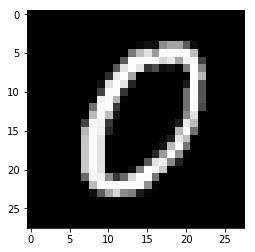

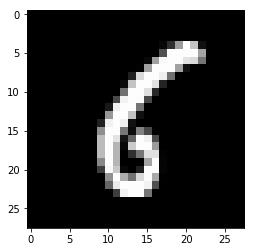

In [3]:
# mnist data reader

def gray_to_rgb(x):
    x = np.array(x[0,:,:]) 
    return torch.tensor(np.stack([x,x,x], axis = -1).reshape((3,28,28)))

normalize = transforms.Normalize((0.1307,), (0.1307,))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 25

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

for i, (inputs, outputs) in enumerate(train_loader):
    for image in inputs.numpy():
        image = image.reshape((28,28))
        plt.imshow(image, cmap = 'gray')
        plt.show()
    break

In [74]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64 * 9, 120)
        self.fc2 = nn.Linear(120,120)
        self.encoding = nn.Linear(120,25)
        self.fc3 = nn.Linear(25,10)
        
        
    def forward(self, x):
        x = x.reshape((x.shape[0],1,28,28))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.encoding(x))
        
        return self.fc3(encoded), encoded
        

    
classifier = Classifier()
classifier(torch.randn((1,1,28,28)))
classifier

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (encoding): Linear(in_features=120, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum = 0.9)
print('done')

done


In [76]:
def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions, encoded = model(inputs)
            loss = metric(predictions, outputs)  
            #loss += 0.0001 * torch.sum(torch.abs(encoded))
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 5, log_every = 100)

0 2.327712059020996 0.12
0 1.9719356959409053 0.28435643564356433
0 1.3746965612789885 0.5116417910447761
0 1.0373110233054208 0.6377408637873754
0 0.8396023592105754 0.708428927680798
0 0.7183858782904382 0.7535329341317365
0 0.6302536900981195 0.7856239600665558
0 0.5617791157630677 0.8101569186875892
0 0.5088208261913633 0.8291136079900124
0 0.4669828501915803 0.8437291897891231
0 0.4308208844339062 0.8561038961038961
0 0.4033702807463951 0.8659400544959128
0 0.3785281802048181 0.8746711074104913
0 0.35943016400558947 0.8811990776325903
0 0.34123319507989336 0.8876516773733047
0 0.32493215623801247 0.893217854763491
0 0.3105689723847834 0.8980137414116177
0 0.299167673005164 0.9023398001175779
0 0.2869160417549771 0.9062742920599667
0 0.2772456260784081 0.9096265123619148
0 0.2681695481490945 0.912743628185907
0 0.25920260327941635 0.9158115183246073
0 0.25128287622343426 0.9183825533848251
0 0.24326445922595605 0.9210777922642329
1 0.007958659902215004 1.0
1 0.056893612484627466 0.

In [77]:
# Monitor accuracy in test and train 
# Quality monitoring visualizaing incorrect and correct in test and train
# Transfer learning
# Image augmentations
# Visualzaing what conv layers learn
# Visualize what activations learn

def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions, encoded = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
    return correct / total
        
        
evaluate(classifier, test_loader)

0.9905

In [ ]:
# find which neurons get activated for a given digit
from collections import defaultdict


def get_activating_neurons(digit, test_loader):
    d = defaultdict(list)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()].append(rep.detach().numpy())
    d[digit] = np.array(d[digit])
    d[digit] = np.mean(d[digit], axis = 0)
    plt.figure(figsize=(10,5))
    plt.bar(range(0,25), d[digit])
    plt.xticks(range(0,25))
    plt.show()
        

for i in range(0,10):
    print('activating neurons for digit ', i)
    get_activating_neurons(i, test_loader)

In [ ]:
### find digits which activate a neuron


def get_activating_digit(dim_number, test_loader):
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()] += rep.detach().numpy()[dim_number]
    d = sorted(d.items())        
    x = [ e[0] for e in d ]
    y = [ e[1] for e in d ]
    plt.bar(x, y)
    plt.xticks(range(0,10), range(0,10))
    plt.show()

for i in range(25):
    print("digit activation graph of neuron " + str(i))
    get_activating_digit(i, test_loader)
        
        
    


ACTIVATION IMAGES AND HEATMAPS


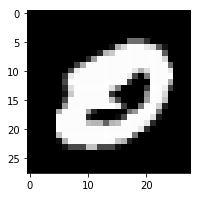

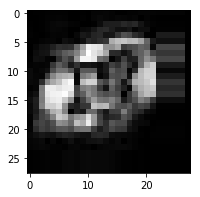

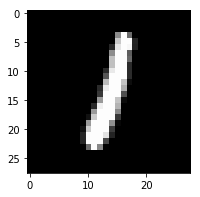

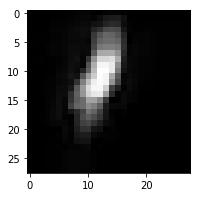

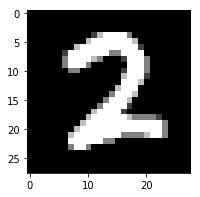

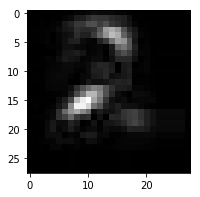

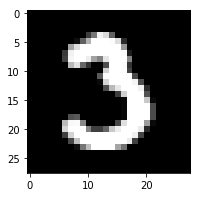

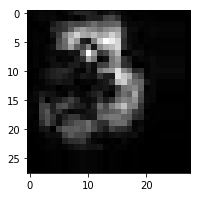

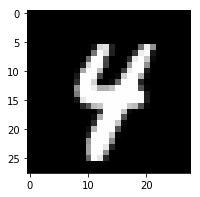

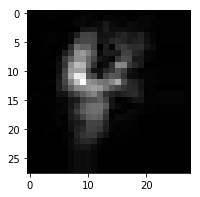

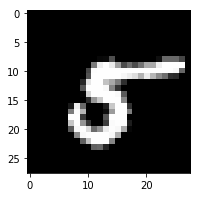

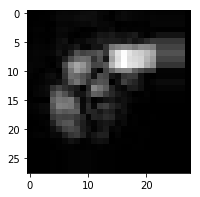

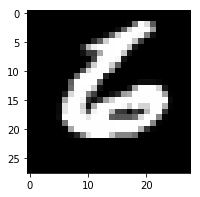

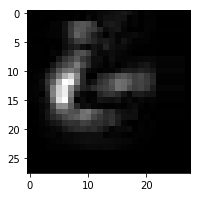

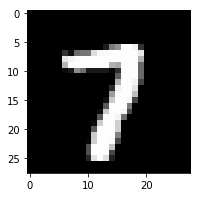

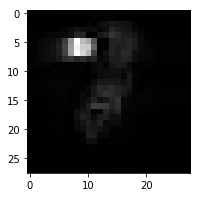

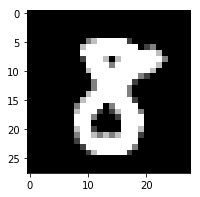

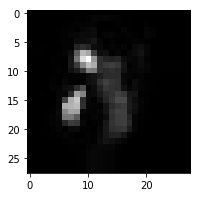

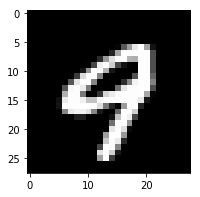

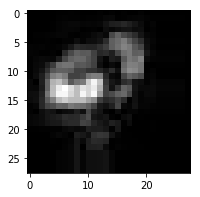

In [88]:
# Find what part of image contributes to probability score by occluding image
from collections import defaultdict

def get_activation_heatmap(digit, test_loader):
    digit_images = None
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        for image, output in zip(inputs, outputs):
            if output.item() == digit:
                digit_image = image
    
   
    heat_map = np.zeros((28,28))
    

    digit_image = digit_image.reshape((28,28,1))
    actual_predictions, actual_encoded = classifier(digit_image.reshape((1,28,28,1)))
    

    for i in range(25):
        for j in range(23):
            occluded_image = digit_image.numpy().copy()
            occluded_image[i:i+5,j:j+5] = 0
            occluded_predictions, occluded_encoded = classifier(torch.tensor(occluded_image.reshape((1,28,28,1))))
            difference = 255 * abs(actual_predictions[0][1].item() - occluded_predictions[0][1].item())
            heat_map[i:i+5,j:j+5] = difference
        
    
    
    plt.figure(figsize=(3,3))
    plt.imshow(digit_image.reshape((28,28)), cmap = 'gray')
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(heat_map, cmap = 'gray')
    plt.show()
        
       

            
print('ACTIVATION IMAGES AND HEATMAPS')      

for digit in range(10):
    get_activation_heatmap(digit, test_loader) 

In [8]:
# Find what part of image contributes to probability score by occluding image


def get_activating_patch(dim_number, test_loader):
    max_activation = 0
    activating_patch = None
    k = 0
    for inputs, outputs in test_loader:
        k += 1
        for image, output in zip(inputs, outputs):
            un_image =  image.numpy()[0].copy() * 0.137 + 0.137
            n_image = image.numpy()[0].copy()

            for i in range(25):
                for j in range(25):
                    un_patch = np.zeros((28,28))
                    patch = np.zeros((28,28))
                    un_patch[i:i+3][j:j+3] = un_image.copy()[i:i+3][j:j+3]
                    patch[i:i+3][j:j+3] = n_image.copy()[i:i+3][j:j+3]
                    predictions, encoded = classifier(torch.tensor(patch, dtype = torch.float32).reshape((1,1,28,28)))
                    if abs(encoded[0][dim_number].item()) > max_activation:
                        max_activation = encoded[0][dim_number].item()
                        activating_patch = un_patch.copy()
        if k>=10:
            break
              
    if activating_patch:
        plt.imshow(activating_patch, cmap = 'gray')         
        plt.show() 
            

                        
                    
                    
    
for i in range(25):
    print('ACTIVATION PATCH FOR NEURON ', i)
    get_activating_patch(i, test_loader)
    

ACTIVATION PATCH FOR NEURON  0


KeyboardInterrupt: 

### localization is a natural result of classification

### Adversarial example generation

In [11]:
for param in classifier.parameters():
        param.requires_grad = False

0 -0.06150539219379425 tensor(0.0615, requires_grad=True)
1000 -958.7968139648438 tensor(958.7968, requires_grad=True)
2000 -2039.703125 tensor(2039.7031, requires_grad=True)
3000 -3120.238037109375 tensor(3120.2380, requires_grad=True)
4000 -4200.94189453125 tensor(4200.9419, requires_grad=True)
5000 -5281.7607421875 tensor(5281.7607, requires_grad=True)
6000 -6362.59521484375 tensor(6362.5952, requires_grad=True)
7000 -7444.85400390625 tensor(7444.8540, requires_grad=True)
8000 -8527.4619140625 tensor(8527.4619, requires_grad=True)
9000 -9611.3408203125 tensor(9611.3408, requires_grad=True)
10000 -10695.41015625 tensor(10695.4102, requires_grad=True)
11000 -11779.4765625 tensor(11779.4766, requires_grad=True)
12000 -12863.4599609375 tensor(12863.4600, requires_grad=True)
13000 -13947.443359375 tensor(13947.4434, requires_grad=True)
14000 -15031.41796875 tensor(15031.4180, requires_grad=True)
15000 -16115.400390625 tensor(16115.4004, requires_grad=True)
16000 -17199.36328125 tensor(17

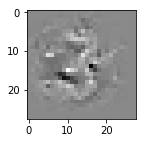

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>)

In [83]:


from scipy import ndimage

def get_fake_examples(digit):
    x = torch.randn((1,1,28,28), requires_grad = True)
    lr = 1
    for i in range(50000):
        predictions, encoded = classifier(x)
        loss = -predictions[0][digit]
        loss.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
            if i % 1000 == 0:
                print(i, loss.item(), predictions[0][digit])

    x = x.detach().numpy()
    x = x.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(x, cmap = 'gray')
    plt.show()

    return torch.softmax(classifier(torch.tensor(x).reshape(1,1,28,28))[0][0], dim = 0)

get_fake_examples(3)

0 0.08039814978837967 tensor(-0.0804, requires_grad=True)
1000 -537.5465698242188 tensor(537.5466, requires_grad=True)
2000 -1326.4317626953125 tensor(1326.4318, requires_grad=True)
3000 -2166.64208984375 tensor(2166.6421, requires_grad=True)
4000 -3021.99169921875 tensor(3021.9917, requires_grad=True)
5000 -3878.14453125 tensor(3878.1445, requires_grad=True)
6000 -4733.01806640625 tensor(4733.0181, requires_grad=True)
7000 -5589.34033203125 tensor(5589.3403, requires_grad=True)
8000 -6447.05224609375 tensor(6447.0522, requires_grad=True)
9000 -7309.73681640625 tensor(7309.7368, requires_grad=True)
10000 -8178.75537109375 tensor(8178.7554, requires_grad=True)
11000 -9051.0029296875 tensor(9051.0029, requires_grad=True)
12000 -9924.75 tensor(9924.7500, requires_grad=True)
13000 -10799.1064453125 tensor(10799.1064, requires_grad=True)
14000 -11672.7314453125 tensor(11672.7314, requires_grad=True)
15000 -12546.4150390625 tensor(12546.4150, requires_grad=True)
16000 -13420.8037109375 tenso

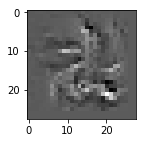

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>)

In [84]:
get_fake_examples(2)

0 -0.12480845302343369 tensor(0.1248, requires_grad=True)
1000 -385.8339538574219 tensor(385.8340, requires_grad=True)
2000 -897.8936767578125 tensor(897.8937, requires_grad=True)
3000 -1415.04150390625 tensor(1415.0415, requires_grad=True)
4000 -1933.43994140625 tensor(1933.4399, requires_grad=True)
5000 -2453.24658203125 tensor(2453.2466, requires_grad=True)
6000 -2973.5400390625 tensor(2973.5400, requires_grad=True)
7000 -3493.7080078125 tensor(3493.7080, requires_grad=True)
8000 -4014.30712890625 tensor(4014.3071, requires_grad=True)
9000 -4534.62060546875 tensor(4534.6206, requires_grad=True)
10000 -5055.06103515625 tensor(5055.0610, requires_grad=True)
11000 -5575.38427734375 tensor(5575.3843, requires_grad=True)
12000 -6095.76025390625 tensor(6095.7603, requires_grad=True)
13000 -6616.05712890625 tensor(6616.0571, requires_grad=True)
14000 -7136.57666015625 tensor(7136.5767, requires_grad=True)
15000 -7656.97802734375 tensor(7656.9780, requires_grad=True)
16000 -8177.322265625 t

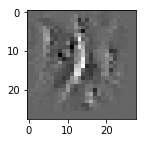

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>)

In [85]:
get_fake_examples(1)

0 0.03509058058261871 tensor(-0.0351, requires_grad=True)
1000 -338.256103515625 tensor(338.2561, requires_grad=True)
2000 -713.9164428710938 tensor(713.9164, requires_grad=True)
3000 -1089.93603515625 tensor(1089.9360, requires_grad=True)
4000 -1468.5347900390625 tensor(1468.5348, requires_grad=True)
5000 -1848.518798828125 tensor(1848.5188, requires_grad=True)
6000 -2228.864990234375 tensor(2228.8650, requires_grad=True)
7000 -2611.7431640625 tensor(2611.7432, requires_grad=True)
8000 -2994.063232421875 tensor(2994.0632, requires_grad=True)
9000 -3376.409912109375 tensor(3376.4099, requires_grad=True)
10000 -3759.02978515625 tensor(3759.0298, requires_grad=True)
11000 -4141.69580078125 tensor(4141.6958, requires_grad=True)
12000 -4524.33154296875 tensor(4524.3315, requires_grad=True)
13000 -4907.94384765625 tensor(4907.9438, requires_grad=True)
14000 -5291.43505859375 tensor(5291.4351, requires_grad=True)
15000 -5674.76318359375 tensor(5674.7632, requires_grad=True)
16000 -6058.09716

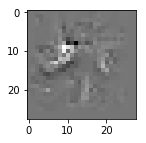

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], grad_fn=<SoftmaxBackward>)

In [81]:
get_fake_examples(7)

0 -0.7060972452163696 tensor(0.7061, requires_grad=True)
1000 -415.3717346191406 tensor(415.3717, requires_grad=True)
2000 -994.8782348632812 tensor(994.8782, requires_grad=True)
3000 -1593.5006103515625 tensor(1593.5006, requires_grad=True)
4000 -2202.994873046875 tensor(2202.9949, requires_grad=True)
5000 -2809.425048828125 tensor(2809.4250, requires_grad=True)
6000 -3416.0966796875 tensor(3416.0967, requires_grad=True)
7000 -4022.889404296875 tensor(4022.8894, requires_grad=True)
8000 -4629.69384765625 tensor(4629.6938, requires_grad=True)
9000 -5236.49755859375 tensor(5236.4976, requires_grad=True)
10000 -5843.89697265625 tensor(5843.8970, requires_grad=True)
11000 -6451.47900390625 tensor(6451.4790, requires_grad=True)
12000 -7059.29736328125 tensor(7059.2974, requires_grad=True)
13000 -7668.65283203125 tensor(7668.6528, requires_grad=True)
14000 -8278.3994140625 tensor(8278.3994, requires_grad=True)
15000 -8888.1171875 tensor(8888.1172, requires_grad=True)
16000 -9501.73828125 te

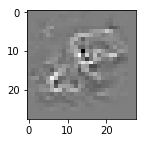

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], grad_fn=<SoftmaxBackward>)

In [82]:
get_fake_examples(8)

0 0.7908716797828674 tensor(-0.7909, requires_grad=True)
1000 -13.097137451171875 tensor(13.0971, requires_grad=True)
2000 -37.97292709350586 tensor(37.9729, requires_grad=True)
3000 -63.557395935058594 tensor(63.5574, requires_grad=True)
4000 -89.50894165039062 tensor(89.5089, requires_grad=True)
5000 -115.42863464355469 tensor(115.4286, requires_grad=True)
6000 -141.39791870117188 tensor(141.3979, requires_grad=True)
7000 -167.4230499267578 tensor(167.4230, requires_grad=True)
8000 -193.47372436523438 tensor(193.4737, requires_grad=True)
9000 -219.57435607910156 tensor(219.5744, requires_grad=True)
10000 -245.6619110107422 tensor(245.6619, requires_grad=True)
11000 -271.7950744628906 tensor(271.7951, requires_grad=True)
12000 -297.9239807128906 tensor(297.9240, requires_grad=True)
13000 -324.0537414550781 tensor(324.0537, requires_grad=True)
14000 -350.1698913574219 tensor(350.1699, requires_grad=True)
15000 -376.2779846191406 tensor(376.2780, requires_grad=True)
16000 -402.392303466

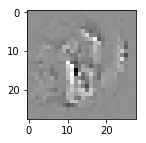

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [67]:
get_fake_examples(0)